# Imports

In [ ]:
import math
import numpy as np
import random as rn
from numpy.random import uniform as rnd, normal as rndn, choice
from matplotlib import pyplot as plt
import time

In [ ]:
# class to print text in different colors
class bcolors:
  HEADER = '\033[95m'
  OKBLUE = '\033[94m'
  OKCYAN = '\033[96m'
  OKGREEN = '\033[92m'
  WARNING = '\033[93m'
  FAIL = '\033[91m'
  ENDC = '\033[0m'
  BOLD = '\033[1m'
  UNDERLINE = '\033[4m'

# Benchmark functions


In [ ]:
class Function:
  def __init__(self, fnc=None):
    self.d = Config.get_dimension()

    benchmarks = {
      'Ackley': self.Ackley,
      'Rastrigin': self.Rastrigin,
      'Rosenbrock': self.Rosenbrock,
      'Schwefel': self.Schwefel,
      'Default': self.def_fnc
    }

    if fnc is None or fnc not in benchmarks:
      self.func_name = 'Default'
      self.f = benchmarks[self.func_name]
    else:
      self.func_name = fnc
      self.f = benchmarks[self.func_name]
    
    print('*' * 25 + ' ' + self.func_name + ' function is set to optimize ' + '*' * 25)

  def compute(self, vector):
    return self.f(vector)

  def Ackley(self, vector):
    a = 20
    b = 0.2
    c = 2 * np.pi

    term_1 = sum(vector ** 2)
    term_2 = sum(np.cos(c * vector))

    f = -a * np.exp(-b * np.sqrt(term_1)) - np.exp(term_2) + a + np.exp(1)

    return f

  def Rastrigin(self, vector):
    c = 2 * np.pi

    term = sum(vector ** 2 - 10 * np.cos(c * vector))

    f = 10 * self.d + term
      
    return f

  def Rosenbrock(self, vector):
    sum = 0

    # print(vector)

    for i in range(1, self.d-1):
      sum += 100 * (vector[i+1] - vector[i] ** 2) ** 2 + (vector[i] - 1) ** 2   

    return sum

  def Schwefel(self, vector):
    
    term = sum(vector * np.sin(np.sqrt(np.absolute(vector))))
    
    f = 418.9829 * self.d - term

    return f

  def def_fnc(self, vector):
    return vector[0]**2.0 + vector[1]**2.0

# Config

In [ ]:
class Config:
  function = None
  populationSize = 30
  dimension = 30
  iteration = 1000
  domainLowerBound = -1
  domainUpperBound = 1
  maxFes = 3000

  #----------------------------------------------------

  @classmethod
  def get_function(cls):
    return cls.function

  @classmethod
  def set_function(cls, function):
    cls.function = function

  #-----------------------------------------------------

  @classmethod
  def get_population_size(cls):
    return cls.populationSize

  @classmethod
  def set_population_size(cls, population_size):
    cls.populationSize = population_size

  #-----------------------------------------------------
  
  @classmethod
  def get_dimension(cls):
    return cls.dimension

  @classmethod
  def set_dimension(cls, dimension):
    cls.dimension = dimension

  #-----------------------------------------------------
  
  @classmethod
  def get_iteration(cls):
    return cls.iteration

  @classmethod
  def set_iteration(cls, iteration):
    cls.iteration = iteration

  #-----------------------------------------------------
  
  @classmethod
  def get_domain_lower_bound(cls):
    return cls.domainLowerBound

  @classmethod
  def set_domain_lower_bound(cls, domain_lower_bound):
    cls.domainLowerBound = domain_lower_bound

  #-----------------------------------------------------
  
  @classmethod
  def get_domain_upper_bound(cls):
    return cls.domainUpperBound

  @classmethod
  def set_domain_upper_bound(cls, domain_upper_bound):
    cls.domainUpperBound = domain_upper_bound

  #-----------------------------------------------------

  @classmethod
  def get_max_fes(cls):
    return cls.maxFes

  @classmethod
  def set_max_fes(cls, max_fes):
    cls.maxFes = max_fes

  #-----------------------------------------------------

# Global Variables

In [ ]:
# global variables
F = 0.5 # Mutation factor
CR = 0.7 # Crossover probability

In [ ]:
available_function_settings = [
    {
        "name": "Ackley",
        "bounds": [-32, 32]
    },
    {
        "name": "Rastrigin",
        "bounds": [-5.12, 5.12]
    },
    {
        "name": "Rosenbrock",
        "bounds": [-30,30]
    },
    {
        "name": "Schwefel",
        "bounds": [-500,500]
    }
]

# Auxiliary Classes

In [ ]:
class Vector:

  def __init__(self):
    self.generate_vector()

  #-----------------------------------------------------

  def generate_vector(self):
    function = Config.get_function()
    dimension = Config.get_dimension()
    domain_lower_bound = Config.get_domain_lower_bound()
    domain_upper_bound = Config.get_domain_upper_bound()

    self.position = np.random.uniform(domain_lower_bound, domain_upper_bound, (dimension,))
    self.fitness = function.compute(self.position)

  #-----------------------------------------------------

  def get_position(self):
    return self.position

  def set_position(self, position):
    self.position = position

  #-----------------------------------------------------

  def get_fitness(self):
    return self.fitness

  def set_fitness(self, fitness):
    self.fitness = fitness  

  #-----------------------------------------------------

  def check_bounds(self):
    dimension = Config.get_dimension()
    domain_lower_bound = Config.get_domain_lower_bound()
    domain_upper_bound = Config.get_domain_upper_bound()

    for i in range(dimension):
      if self.position[i] < domain_lower_bound:
        self.position[i] = domain_lower_bound
      
      if self.position[i] > domain_upper_bound:
        self.position[i] = domain_upper_bound

# DE

In [ ]:
class DE:
  def __init__(self):
    self.cur_iter = 0

  def initialization(self):
    self.p = []

    for i in range(Config.get_population_size()):
      self.p.append(Vector())

    self.p = sorted(self.p, key=lambda individual: individual.get_fitness())

    self.BestPosition = self.p[0].get_position()
    self.BestFitness = self.p[0].get_fitness()
    self.PrevBestFitness = self.BestFitness
    self.BestResults = []
    self.AverageResults = []

  def get_random_individuals(self, current_index, num_of_vectors):
    candidates = [cand for cand in range(Config.get_population_size()) if cand != current_index]
    idx = choice(candidates, num_of_vectors, replace=False)
    return [self.p[i] for i in idx]

  def total_evaluation(self):
    temp = sorted(self.p, key=lambda individual: individual.get_fitness())

    self.BestFitness = temp[0].get_fitness()

    if self.BestFitness < self.PrevBestFitness:
      self.BestPosition = temp[0].get_position()
      self.PrevBestFitness = self.BestFitness
      self.BestResults.append(self.BestFitness)
    
  def visualize(self):
    plt.plot(self.BestResults)
    plt.plot(self.AverageResults)
    plt.legend()
    plt.xlabel('Iterations')
    plt.ylabel('Objective Function Value')
    plt.show()

# SDE


In [ ]:
class SDE(DE):

  def __init__(self, f, cr):
    super().__init__()
    self.f = f
    self.cr = cr

    population_size = Config.get_population_size()

    if population_size < 4:
      print('The population size must be equal or greater than 4!')  
      return

    if f < 0 or f > 2:
      print('The mutation factor must be between 0 and 2!')  
      return

    if cr < 0 or f > 1:
      print('The crossover probability must be between 0 and 1!')  
      return
    
    self.launch()
    
  def initialization(self):
    super().initialization()

  def generation(self):
    self.x_i = self.p[self.cur_index]
    self.random_vectors = super().get_random_individuals(self.cur_index, 3)
    
  def mutation(self):
    [a, b, c] = self.random_vectors

    self.v_i = Vector()
    self.v_i.set_position( a.get_position() + self.f * ( b.get_position() - c.get_position() ) )

  def crossover(self):
    u_i = Vector()

    dimension = Config.get_dimension()

    j_rand = rn.randrange(0, dimension)

    for j in range(dimension):
      if self.x_i.position[j] < self.cr or j == j_rand:
        u_i.position[j] = self.v_i.position[j]
      else:
        u_i.position[j] = self.x_i.position[j]

    self.u_i = u_i

  def evaluation(self):
    function = Config.get_function()
    
    TargetFitness = function.compute(self.x_i.get_position())
    TrialFitness = function.compute(self.u_i.get_position())

    if TrialFitness < TargetFitness:
      self.p[self.cur_index].set_position(self.u_i.get_position())
      self.p[self.cur_index].set_fitness(TrialFitness)
  
  def launch(self):
    self.initialization()

    print(bcolors.OKGREEN + '-' * 25 + bcolors.ENDC)

    for i in range(Config.get_iteration()):
      self.cur_iter = i 
      for j in range(Config.get_population_size()):
        self.cur_index = j
        self.generation()
        self.mutation()
        self.crossover()
        self.evaluation()

      super().total_evaluation()

      print('Iteration: %d --> f([%s]) = %.5f' % (self.cur_iter + 1, np.around(self.BestPosition, decimals=5), self.BestFitness))

    super().visualize()
    print(bcolors.OKGREEN + "-" * 25 + bcolors.ENDC)

In [ ]:
fnc = Function(fnc=available_function_settings[2]["name"])
bounds = available_function_settings[2]["bounds"]

Config.set_function(fnc)
Config.set_domain_lower_bound(bounds[0])
Config.set_domain_upper_bound(bounds[1])

************************* Rosenbrock function is set to optimize *************************


-------------------------
Iteration: 1 --> f([[ -4.54884 -10.06794  11.62294  -2.29401 -20.90068 -18.93093   7.71856
   6.44684 -10.4286    0.41236 -28.93728 -17.0172   16.44124 -18.82401
  23.80063 -27.70286  10.49332  13.8762   -0.29918   4.31763 -10.23678
  15.44074 -19.60695   4.28217  -3.27604 -14.50508  19.46646 -12.20559
   2.10183  13.48075]]) = 277852407.62814
Iteration: 2 --> f([[ 11.3371   -7.86078  28.90814  18.4022   25.23402  17.88567  12.64705
   8.28155   8.69327   1.21044  20.48458   7.95365  24.70886  24.85965
  18.21688   1.72669   7.78064  12.54843   4.9702   19.17247  -8.1941
  -3.9027    8.26645  -6.71968   4.59391 -18.16605   8.26947  20.94469
  10.76265   4.67738]]) = 274184871.11914
Iteration: 3 --> f([[  1.05652  19.46382 -14.26862  11.67096   1.6122    9.12388   1.41627
   4.61325  -4.8334   18.13954   5.93669  14.61275  23.89382   8.58749
  11.59279  24.29567  29.2813    7.71791  -3.02896 -12.30798  13.79649
  10.69066  -4.70029  23.78548  25.57955   7.91144

No handles with labels found to put in legend.


Iteration: 998 --> f([[17.25468  1.00271  1.00528  1.00807  1.01392  1.00805  1.01432  1.03395
  1.02776  1.02667  1.03279  1.02482  1.03606  1.03914  1.02618  1.0382
  1.04005  1.03843  1.03321  1.02292  1.02873  1.03324  1.03921  1.05704
  1.09632  1.16801  1.35793  1.91324  3.68606 13.755  ]]) = 13.69565
Iteration: 999 --> f([[17.25468  1.00271  1.00528  1.00807  1.01392  1.00805  1.01432  1.03395
  1.02776  1.02667  1.03279  1.02482  1.03606  1.03914  1.02618  1.0382
  1.04005  1.03843  1.03321  1.02292  1.02873  1.03324  1.03921  1.05704
  1.09632  1.16801  1.35793  1.91324  3.68606 13.755  ]]) = 13.69565
Iteration: 1000 --> f([[17.25468  1.00271  1.00528  1.00807  1.01392  1.00805  1.01432  1.03395
  1.02776  1.02667  1.03279  1.02482  1.03606  1.03914  1.02618  1.0382
  1.04005  1.03843  1.03321  1.02292  1.02873  1.03324  1.03921  1.05704
  1.09632  1.16801  1.35793  1.91324  3.68606 13.755  ]]) = 13.69565


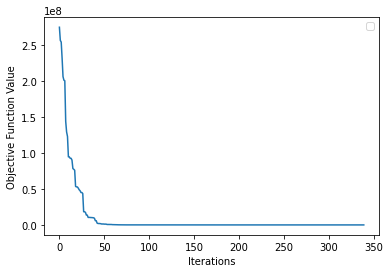

-------------------------


In [ ]:
start = time.time()
sde = SDE(F, CR)
end = time.time()

In [ ]:
print(f"Time taken for SDE to find the most optimal value is {end - start} seconds")

Time taken for SDE to find the most optimal value is 12.191958665847778 seconds


# CODE

In [ ]:
class CODE(DE):

  def __init__(self, parameter_candidate_pool):
    super().__init__()
    self.parameter_candidate_pool = parameter_candidate_pool
    self.launch()
    
  def initialization(self):
    super().initialization()

  def rand_1_bin(self):
    [f, cr] = self.parameter_candidate_pool[0]

    vectors = super().get_random_individuals(self.cur_index, 3)

    u_i_1_g = Vector()

    dimension = Config.get_dimension()
    function = Config.get_function()

    cutPoint = rn.randint(0, dimension-1)

    for i in range(dimension):
      if i == cutPoint or rnd(0,1) < cr:
        u_i_1_g.position[i] = vectors[2].position[i] + f * ( vectors[0].position[i] - vectors[1].position[i] )
      else:
        u_i_1_g.position[i] = self.p[self.cur_index].position[i]

    u_i_1_g.check_bounds()

    u_i_1_g.set_fitness(function.compute(u_i_1_g.get_position()))

    self.trialVectors.append(u_i_1_g)

  def rand_2_bin(self):
    [f, cr] = self.parameter_candidate_pool[1]

    vectors = super().get_random_individuals(self.cur_index, 5)

    u_i_2_g = Vector()

    dimension = Config.get_dimension()
    function = Config.get_function()

    cutPoint = rn.randint(0, dimension-1)

    for i in range(dimension):
      if i == cutPoint or rnd(0,1) < cr:
        u_i_2_g.position[i] = vectors[0].position[i] + f * ( vectors[1].position[i] - vectors[2].position[i] ) + f * ( vectors[3].position[i] - vectors[4].position[i] )
      else:
        u_i_2_g.position[i] = self.p[self.cur_index].position[i]

    u_i_2_g.check_bounds()

    u_i_2_g.set_fitness(function.compute(u_i_2_g.get_position()))
    self.trialVectors.append(u_i_2_g)

  def current_to_rand_1(self):
    vectors = super().get_random_individuals(self.cur_index, 3)

    [f, cr] = self.parameter_candidate_pool[2]

    function = Config.get_function()

    u_i_3_g = Vector()
    cur_ind = self.p[self.cur_index]

    u_i_3_g.set_position( cur_ind.get_position() + rnd(0,1) * ( vectors[0].get_position() - cur_ind.get_position() ) + f * ( vectors[1].get_position() - vectors[2].get_position() ) )
    u_i_3_g.check_bounds()

    u_i_3_g.set_fitness(function.compute(u_i_3_g.get_position()))

    self.trialVectors.append(u_i_3_g)

  def generation(self):
    self.trialVectors = []
    self.rand_1_bin()
    self.rand_2_bin()
    self.current_to_rand_1()

  def evaluation(self):
    trialVectors = sorted(self.trialVectors, key=lambda individual: individual.get_fitness())

    trialPosition = trialVectors[0].get_position()
    trialFitness = trialVectors[0].get_fitness()

    targetFitness = self.p[self.cur_index].get_fitness()

    if trialFitness <= targetFitness:
      self.p[self.cur_index].set_position(trialPosition)
      self.p[self.cur_index].set_fitness(trialFitness)

  def launch(self):
    self.initialization()

    max_fes = Config.get_max_fes()
    iterations = Config.get_iteration()
    population_size = Config.get_population_size()

    print(bcolors.OKGREEN + '-' * 25 + bcolors.ENDC)
    
    self.cur_iter = 1  

    fes = population_size
    
    while fes < max_fes:
      for i in range(population_size):
        self.cur_index = i
        self.generation()
        self.evaluation()

      fes += 3
      self.cur_iter += 1  
      
      super().total_evaluation()

      print('Iteration: %d --> f([%s]) = %.5f' % (self.cur_iter, np.around(self.BestPosition, decimals=5), self.BestFitness))
    
    super().visualize()
    print(bcolors.OKGREEN + "-" * 25 + bcolors.ENDC)

In [ ]:
fnc = Function(fnc=available_function_settings[2]["name"])
bounds = available_function_settings[2]["bounds"]

Config.set_function(fnc)
Config.set_domain_lower_bound(bounds[0])
Config.set_domain_upper_bound(bounds[1])

parameter_candidate_pool = [[1.0,0.1], [1.0,0.9], [0.8,0.2]]

************************* Rosenbrock function is set to optimize *************************


-------------------------
Iteration: 2 --> f([[  4.27438 -13.70545   2.8482   19.78345  16.0892  -24.13168 -14.8471
  -2.88482 -10.29476  -8.09491  -7.61969  13.13273  -8.65426  -1.70676
  25.07307 -20.35608 -24.2876   21.98553 -12.77296  11.97046   9.85541
   9.13028 -12.9425   12.33012   2.55585  -8.45256  11.24806  28.03628
  10.4693   29.8033 ]]) = 262956921.75640
Iteration: 3 --> f([[  4.27438 -13.70545   2.8482   19.78345  16.0892  -24.13168 -14.8471
  -2.88482 -10.29476  -8.09491  -7.61969  13.13273  -8.65426  -1.70676
  25.07307 -20.35608 -24.2876   21.98553 -12.77296  11.97046   9.85541
   9.13028 -12.9425   12.33012   2.55585  -8.45256  11.24806  28.03628
  10.4693   29.8033 ]]) = 262956921.75640
Iteration: 4 --> f([[  4.27438 -13.70545   2.8482   19.78345  16.0892  -24.13168 -14.8471
  -2.88482 -10.29476  -8.09491  -7.61969  13.13273  -8.65426  -1.70676
  25.07307 -20.35608 -24.2876   21.98553 -12.77296  11.97046   9.85541
   9.13028 -12.9425   12.33012   2.55585  -8.45256  

No handles with labels found to put in legend.


Iteration: 974 --> f([[ 3.0000e+01  5.3455e-01  2.5973e-01 -1.6195e-01  3.5370e-02 -1.0868e-01
  1.3853e-01  4.1550e-02 -3.1620e-02  2.3580e-02 -2.7488e-01  2.4250e-01
  8.1790e-02  8.1860e-02 -5.2470e-02  9.5030e-02  8.8470e-02 -1.2071e-01
  1.7398e-01  1.4089e-01  2.9290e-01  3.6234e-01  3.4700e-02  1.3262e-01
 -4.0222e-01  5.5411e-01  6.5990e-01  4.3449e-01  1.5500e-03  1.7050e-01]]) = 119.70964
Iteration: 975 --> f([[ 3.0000e+01  5.3455e-01  2.5973e-01 -1.6195e-01  3.5370e-02 -1.0868e-01
  1.3853e-01  4.1550e-02 -3.1620e-02  2.3580e-02 -2.7488e-01  2.4250e-01
  8.1790e-02  8.1860e-02 -5.2470e-02  9.5030e-02  8.8470e-02 -1.2071e-01
  1.7398e-01  1.4089e-01  2.9290e-01  3.6234e-01  3.4700e-02  1.3262e-01
 -4.0222e-01  5.5411e-01  6.5990e-01  4.3449e-01  1.5500e-03  1.7050e-01]]) = 119.70964
Iteration: 976 --> f([[ 3.0000e+01  5.3455e-01  2.5973e-01 -1.6195e-01  3.5370e-02 -1.0868e-01
  1.3853e-01  4.1550e-02 -3.1620e-02  2.3580e-02 -2.7488e-01  2.4250e-01
  8.1790e-02  8.1860e-02 -5.

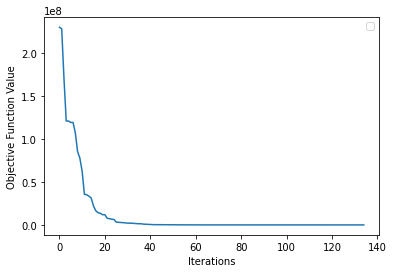

-------------------------


In [ ]:
start = time.time()
code = CODE(parameter_candidate_pool)
end = time.time()

In [ ]:
print(f"Time taken for CODE to find the most optimal value is {end - start} seconds")

Time taken for CODE to find the most optimal value is 27.79290771484375 seconds


# JDE

In [ ]:
class JDE(DE):

  def __init__(self, f, cr):
    super().__init__()
    self.f = f
    self.cr = cr

    population_size = Config.get_population_size()

    if population_size < 4:
      print('The population size must be equal or greater than 4!')  
      return

    if f < 0 or f > 2:
      print('The mutation factor must be between 0 and 2!')  
      return

    if cr < 0 or f > 1:
      print('The crossover probability must be between 0 and 1!')  
      return
    
    self.FLower = 0.1
    self.FUpper = 0.9
    self.Probability = 0.1

    self.launch()
    
  def initialization(self):
    super().initialization()

  def generation(self):
    self.x_i = self.p[self.cur_index]
    self.random_vectors = super().get_random_individuals(self.cur_index, 3)
    
  def mutation(self):
    [a, b, c] = self.random_vectors

    self.v_i = Vector()
    self.v_i.set_position( a.get_position() + self.f * ( b.get_position() - c.get_position() ) )

  def crossover(self):
    u_i = Vector()

    dimension = Config.get_dimension()

    j_rand = rn.randrange(0, dimension)

    for j in range(dimension):
      if self.x_i.position[j] < self.cr or j == j_rand:
        u_i.position[j] = self.v_i.position[j]
      else:
        u_i.position[j] = self.x_i.position[j]

    self.u_i = u_i

  def evaluation(self):
    function = Config.get_function()
    
    TargetFitness = function.compute(self.x_i.get_position())
    TrialFitness = function.compute(self.u_i.get_position())

    if TrialFitness < TargetFitness:
      self.p[self.cur_index].set_position(self.u_i.get_position())
      self.p[self.cur_index].set_fitness(TrialFitness)

  def parameter_setter(self):
    if rnd() < self.Probability:
      self.f = self.FLower + rnd() * self.FUpper

    if rnd() < self.Probability:
      self.cr = rnd()

  
  def launch(self):
    self.initialization()

    print(bcolors.OKGREEN + '-' * 25 + bcolors.ENDC)

    for i in range(Config.get_iteration()):
      self.cur_iter = i 
      for j in range(Config.get_population_size()):
        self.cur_index = j
        self.generation()
        self.parameter_setter()
        self.mutation()
        self.crossover()
        self.evaluation()

      super().total_evaluation()

      print('Iteration: %d --> f([%s]) = %.5f' % (self.cur_iter + 1, np.around(self.BestPosition, decimals=5), self.BestFitness))

    super().visualize()
    print(bcolors.OKGREEN + "-" * 25 + bcolors.ENDC)

In [ ]:
fnc = Function(fnc=available_function_settings[2]["name"])
bounds = available_function_settings[2]["bounds"]

Config.set_function(fnc)
Config.set_domain_lower_bound(bounds[0])
Config.set_domain_upper_bound(bounds[1])

************************* Rosenbrock function is set to optimize *************************


-------------------------
Iteration: 1 --> f([[ -3.95974  -8.29992   4.74358  19.27594   9.15655  -4.27027  -7.6411
  22.42251   2.86926  -5.15099  16.70682 -12.60342   0.94432  11.10166
  21.60995   8.26484   6.27392 -17.95373  -7.0763   24.8531   -4.74763
 -12.77191  12.59382 -20.81224   6.98946  10.37554  21.83749 -19.47239
  15.83588  15.17204]]) = 191044608.23850
Iteration: 2 --> f([[ -3.95974  -8.29992   4.74358  19.27594   9.15655  -4.27027  -7.6411
  22.42251   2.86926  -5.15099  16.70682 -12.60342   0.94432  11.10166
  21.60995   8.26484   6.27392 -17.95373  -7.0763   24.8531   -4.74763
 -12.77191  12.59382 -20.81224   6.98946  10.37554  21.83749 -19.47239
  15.83588  15.17204]]) = 191044608.23850
Iteration: 3 --> f([[ -3.95974  -8.29992   4.74358  19.27594   9.15655  -4.27027  -7.6411
  22.42251   2.86926  -5.15099  16.70682 -12.60342   0.94432  11.10166
  21.60995   8.26484   6.27392 -17.95373  -7.0763   24.8531   -4.74763
 -12.77191  12.59382 -20.81224   6.98946  10.37554  

No handles with labels found to put in legend.


Iteration: 989 --> f([[22.48094  1.01236  1.0142   1.01105  1.02457  1.03239  1.02908  1.0291
  1.02699  1.02865  1.02167  1.01142  1.02175  1.01441  1.02299  1.03736
  1.03173  1.04097  1.06135  1.03772  1.04348  1.0388   1.0385   1.06995
  1.11367  1.2257   1.40698  1.847    3.47011 12.18858]]) = 14.79173
Iteration: 990 --> f([[22.48094  1.01236  1.0142   1.01105  1.02457  1.03239  1.02908  1.0291
  1.02699  1.02865  1.02167  1.01142  1.02175  1.01441  1.02299  1.03736
  1.03173  1.04097  1.06135  1.03772  1.04348  1.0388   1.0385   1.06995
  1.11367  1.2257   1.40698  1.847    3.47011 12.18858]]) = 14.79173
Iteration: 991 --> f([[22.48094  1.01236  1.0142   1.01105  1.02457  1.03239  1.02908  1.0291
  1.02699  1.02865  1.02167  1.01142  1.02175  1.01441  1.02299  1.03736
  1.03173  1.04097  1.06135  1.03772  1.04348  1.0388   1.0385   1.06995
  1.11367  1.2257   1.40698  1.847    3.47011 12.18858]]) = 14.79173
Iteration: 992 --> f([[22.48094  1.01236  1.0142   1.01105  1.02457  1.03

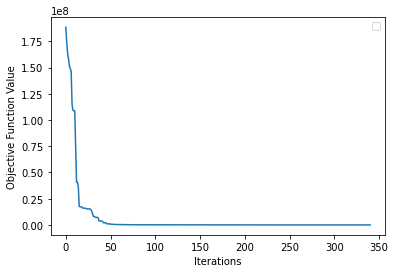

-------------------------


In [ ]:
start = time.time()
sde = JDE(F, CR)
end = time.time()

In [ ]:
print(f"Time taken for JDE to find the most optimal value is {end - start} seconds")

Time taken for JDE to find the most optimal value is 12.852986335754395 seconds


# JADE

# SADE